# 통신사 고객의 가입 해지 여부 예측 모델

## 데이터
- gender(성별)<br>
    Whether the customer is a male or a female


- SeniorCitizen(고령자 여부)<br>
    Whether the customer is a senior citizen or not (1, 0)


- Partner(배우자 유무)<br>
    Whether the customer has a partner or not (Yes, No)


- Dependents(부양가족 유무)<br>
    Whether the customer has dependents or not (Yes, No)


- tenure(근속월수)<br>
    Number of <strong>months</strong> the customer has stayed with the company


- PhoneService(휴대폰 유무)<br>
    Whether the customer has a phone service or not (Yes, No)


- MultipleLines(휴대폰 2개 이상 여부)<br>
    Whether the customer has multiple lines or not (Yes, No, No phone service)


- InternetService(인터넷 이용 여부 + 종류)<br>
    Customer’s internet service provider (DSL, Fiber optic, No)


- OnlineSecurity(보안 설정 여부)<br>
    Whether the customer has online security or not (Yes, No, No internet service)
    
    
- OnlineBackup(온라인 백업 여부)<br>
    Whether the customer has online backup or not (Yes, No, No internet service)

 
- DeviceProtection(단말기 보안 설정 여부)<br>
    Whether the customer has device protection or not (Yes, No, No internet service)


- TechSupport(기술 지원 여부)<br>
    Whether the customer has tech support or not (Yes, No, No internet service)


- StreamingTV(TV 시청 여부) <br>
    Whether the customer has streaming TV or not (Yes, No, No internet service)


- StreamingMovies(영화 시청 여부) <br>
    Whether the customer has streaming movies or not (Yes, No, No internet service)


- Contract(약정 기간) <br>
    The contract term of the customer (Month-to-month, One year, Two year)


- PaperlessBilling(디지털 청구서 수신 여부) <br>
    Whether the customer has paperless billing or not (Yes, No)


- PaymentMethod(결제 방식)<br>
    The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))


- MonthlyCharges(월 지불 금액)  <br>
    The amount charged to the customer monthly


- TotalCharges(지불할 총 금액) <br>
    The total amount charged to the customer


- Churn (가입 해지 여부)<br>
    Whether the customer churned or not (Yes or No)

In [263]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 13.0

In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

In [265]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        main_df = pd.read_csv(os.path.join(dirname, filename))

In [266]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [267]:
main_df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Length: 7043, dtype: bool

In [268]:
main_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


------------------------------
object 타입이 많다. <br>
타입 변환이 필요해보인다.<br><br>



In [269]:
main_df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

----------------
nunique값을 보니 Yes, No 형식이 제대로 맞춰져있나보다. (ex) YeS,YES,no,no phone service 이런식으로 되어 있는게 없다)

In [270]:
main_df.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

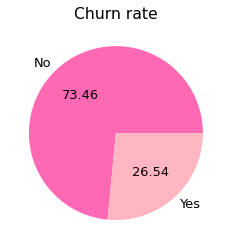

In [271]:
plt.title("Churn rate")
plt.pie(main_df.Churn.value_counts(), labels= main_df.Churn.value_counts().keys(), autopct = "%.2f", colors= ['hotpink', 'lightpink'])
plt.show()

-------
데이터 불균형이 확인되었다. EDA 후 리샘플링을 수행해야겠다.

<br><br><br>
# 전처리
- 타입 변환
- 결측값 처리

## 총지불금액(TotalCharges) -> float

In [272]:
main_df['TotalCharges'] = main_df['TotalCharges'].replace(' ','0').astype(float) 


In [273]:
main_df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [274]:
main_df.loc[main_df.TotalCharges == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0.0,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0.0,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0.0,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0.0,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0.0,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0.0,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0.0,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0.0,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0.0,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0.0,No


-----------------
TotalCharges가 누락된 고객명단 -> contract를 참고해서 예측값을 넣자

## Contract -> int

In [275]:
dic = {'Month-to-month':1, 'One year':12, 'Two year': 24} 
for c in main_df.Contract.unique():
    main_df.Contract.replace(c,dic[c], inplace = True)

## TotalCharges 누락값 계산 : MonthlyCharges * Contract

In [276]:
#TotalCharges가 0인 고객 예측값    
main_df['TotalCharges'].replace(0.0,main_df['MonthlyCharges']*main_df['Contract'], inplace = True)

In [277]:
main_df.loc[main_df.TotalCharges == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


-------------------
이제 모든 고객의 TotalCharges가 채워졌다.

In [278]:
main_df.TotalCharges.describe()

count    7043.000000
mean     2281.253259
std      2265.703526
min        18.800000
25%       401.900000
50%      1396.250000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64

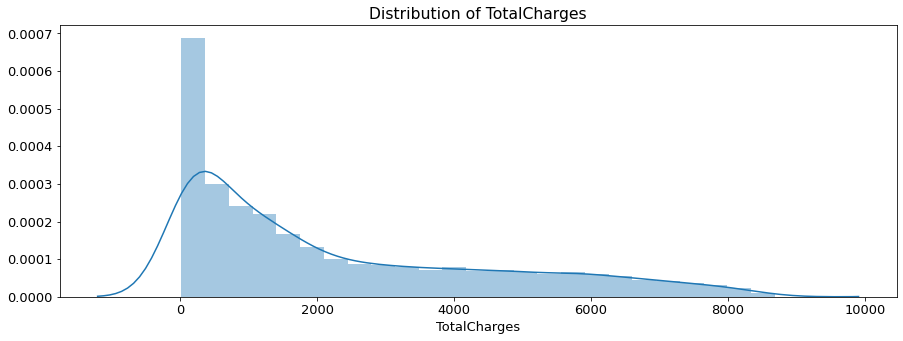

In [279]:
plt.figure(figsize=(15,5))
sns.distplot(main_df.TotalCharges)
plt.xlabel("TotalCharges")
plt.title("Distribution of TotalCharges")
plt.show()

In [280]:
main_df.TotalCharges.nunique()

6541

-----------
그런데 값의 분포가 너무 넓어서 binning을 수행해야할 것 같다.

In [281]:
tmp_min = main_df.TotalCharges.min() #최솟값
tmp_max = main_df.TotalCharges.max() #최댓값
tmp_mean = main_df.TotalCharges.mean() #평균
bins = [tmp_min-1,tmp_mean/7,tmp_mean/2,tmp_mean,tmp_max/2,tmp_max] #최소~평균/7,평균/7~평균/2,평균/2 ~평균,평균~최대/2,최대/2~최대 
bins

[17.8,
 325.89332265065667,
 1140.6266292772984,
 2281.253258554597,
 4342.4,
 8684.8]

In [282]:
main_df['TotalCharges_bin'] = pd.cut(main_df.TotalCharges, bins, labels = list(range(len(bins)-1)))
main_df['TotalCharges_bin'].head()

0    0
1    2
2    0
3    2
4    0
Name: TotalCharges_bin, dtype: category
Categories (5, int64): [0 < 1 < 2 < 3 < 4]

In [283]:
main_df.TotalCharges_bin.value_counts()

0    1579
1    1548
4    1467
2    1267
3    1182
Name: TotalCharges_bin, dtype: int64

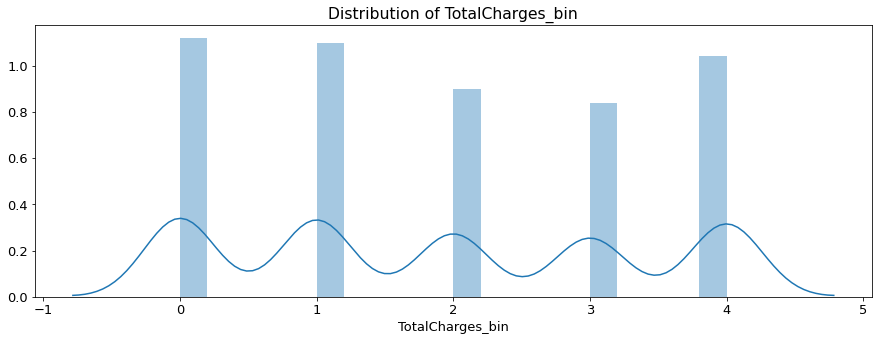

In [284]:
plt.figure(figsize=(15,5))
sns.distplot(main_df.TotalCharges_bin)
plt.xlabel("TotalCharges_bin")
plt.title("Distribution of TotalCharges_bin")
plt.show()

------------------
5개의 그룹을 생성하여 분포의 범위를 줄였고, 그룹당 구성원 수도 비슷하게 맞추었다. 

## object -> category

In [285]:
main_df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6541
Churn                  2
TotalCharges_bin       5
dtype: int64

In [286]:
# from sklearn.preprocessing import LabelEncoder
# Encoder = LabelEncoder()
# for c in filter(lambda x: (main_df[x].dtype == 'O' and main_df[x].nunique() <=4 and x!='Churn') or x=='SeniorCitizen', main_df.columns):
#     main_df[c]= Encoder.fit_transform(main_df[c])

In [287]:
for c in filter(lambda x: (main_df[x].dtype == 'O' and main_df[x].nunique() <=4) or x=='SeniorCitizen', main_df.columns):
    main_df[c] = main_df[c].astype("category")

In [288]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   int64   
 16  PaperlessBilling  7043 n

In [289]:
main_df.describe()

,tenure,Contract,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,8.835865,64.761692,2281.253259
std,24.559481,9.551444,30.090047,2265.703526
min,0.000000,1.000000,18.250000,18.800000
25%,9.000000,1.000000,35.500000,401.900000
50%,29.000000,1.000000,70.350000,1396.250000
75%,55.000000,12.000000,89.850000,3786.600000
max,72.000000,24.000000,118.750000,8684.800000


--------------------------------
customerID를 제외한 모든 object타입을 적절한 타입으로 변환시켰다.

<br><br><br>
# EDA
- 각 속성과 Churn의 상관관계 분석
- 속성 간의 상관관계 분석
- 분석을 토대로 구체적인 가설을 세우고 검증하기


**필요에 따라 파생속성 생성*

In [290]:
#시각화를 위한 color 딕셔너리
color_dic = {0:['#005b6e','#04668c'],1:['#3c6ca7','#786eb7'],2:['#a86bba','#da66ac'],
             3:['#ff6792','#aa6792'],4:['#d8e0bb','#b6cec7'],5:['#ff5050','#ffaa00'],
            6:['#ff99ff','#ff6699',],7:['#e6f2ff','#99ccff'],8:['#ccccff','#cc99ff'],
            9:['#ff9966', '#ff6600']}

## TotalCharges와 Churn의 상관관계

No     3001
Yes    1393
Name: Churn, dtype: int64
No     2173
Yes     476
Name: Churn, dtype: int64
No     871
Yes    708
Name: Churn, dtype: int64
No     1254
Yes     213
Name: Churn, dtype: int64


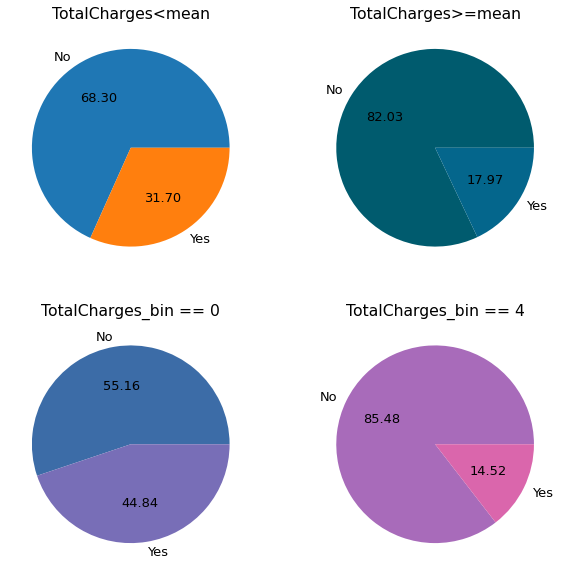

In [291]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("TotalCharges<mean")
print(main_df.loc[main_df.TotalCharges<tmp_mean].Churn.value_counts())
plt.pie(main_df.loc[main_df.TotalCharges<tmp_mean].Churn.value_counts(),autopct ='%.2f', labels=['No','Yes'])
plt.subplot(2,2,2)
plt.title("TotalCharges>=mean")
print(main_df.loc[main_df.TotalCharges>=tmp_mean].Churn.value_counts())
plt.pie(main_df.loc[main_df.TotalCharges>tmp_mean].Churn.value_counts(),autopct ='%.2f', labels=['No','Yes'], colors=color_dic[0])
plt.subplot(2,2,3)
plt.title("TotalCharges_bin == 0")
print(main_df.loc[main_df.TotalCharges_bin==0].Churn.value_counts())
plt.pie(main_df.loc[main_df.TotalCharges_bin==0].Churn.value_counts(),autopct ='%.2f', labels=['No','Yes'], colors=color_dic[1])
plt.subplot(2,2,4)
plt.title("TotalCharges_bin == 4")
print(main_df.loc[main_df.TotalCharges_bin==4].Churn.value_counts())
plt.pie(main_df.loc[main_df.TotalCharges_bin==4].Churn.value_counts(),autopct ='%.2f', labels=['No','Yes'], colors=color_dic[2])
plt.show()

--------------------
위 결과를 보았을 때 TotalCharges이 높은 고객은 확실히 해지율이 낮다.<br><br>
그리고 그 차이는 양 끝단(TotalCharges가 아주 낮거나 아주 높을 때)에서 더 확연하다.

## Tenure과 Churn의 상관관계

No     2315
Yes    1460
Name: Churn, dtype: int64
No     2859
Yes     409
Name: Churn, dtype: int64


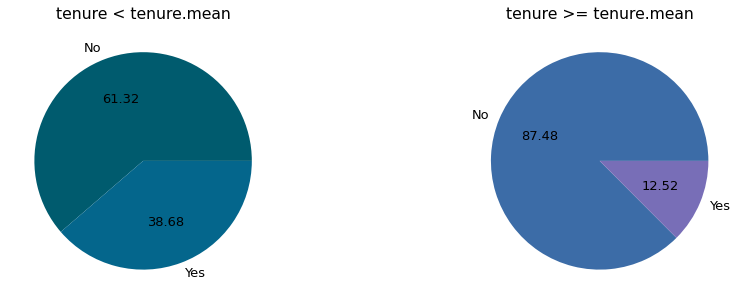

In [292]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("tenure < tenure.mean")
print(main_df.loc[main_df.tenure<main_df.tenure.mean()].Churn.value_counts())
plt.pie(main_df.loc[main_df.tenure<main_df.tenure.mean()].Churn.value_counts(), labels=['No','Yes'],autopct="%.2f",colors=color_dic[0])
plt.subplot(1,2,2)
plt.title("tenure >= tenure.mean")
print(main_df.loc[main_df.tenure>=main_df.tenure.mean()].Churn.value_counts())
plt.pie(main_df.loc[main_df.tenure>=main_df.tenure.mean()].Churn.value_counts(), labels=['No','Yes'],autopct="%.2f",colors = color_dic[1])

plt.show()

---------------------------
평균을 기준으로 근속월수가 높은 사람이 낮은 사람보다 해지 않을 확률이 훨씬 높다.

## Contract과 Churn의 상관관계

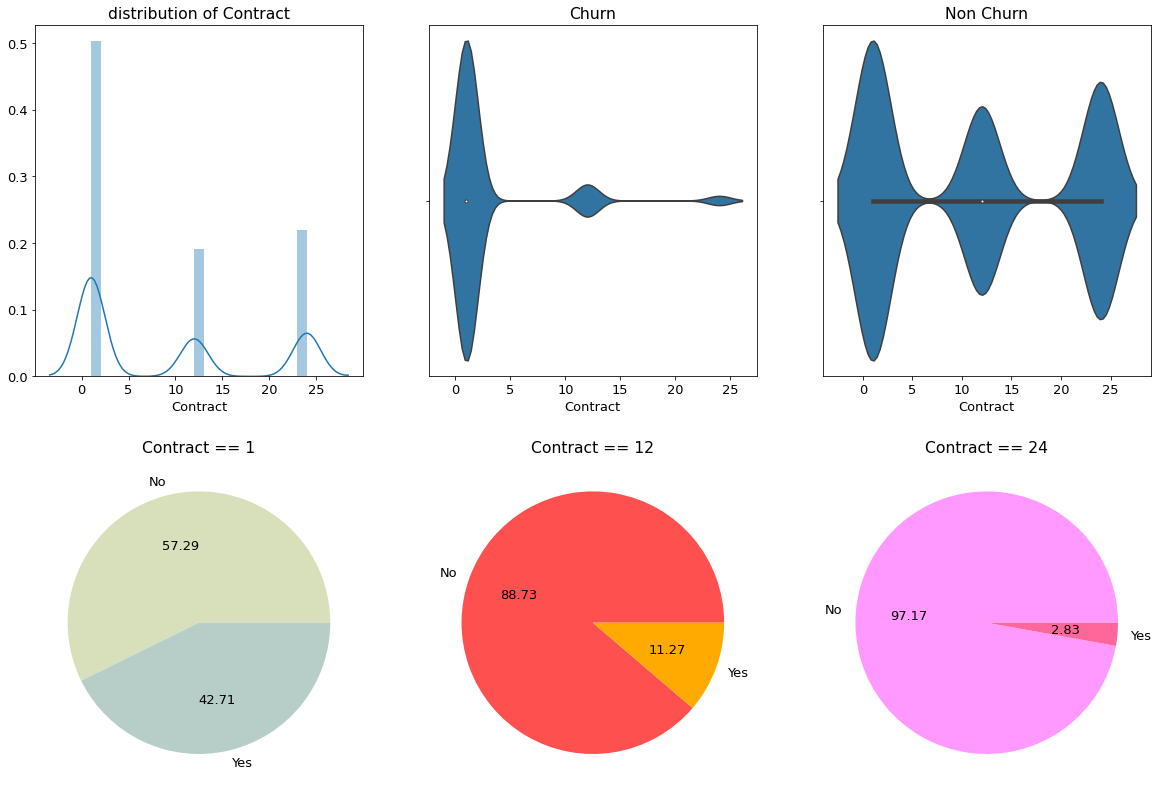

In [293]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(top=1.2)
plt.subplot(2,3,1)
plt.title("distribution of Contract")
sns.distplot(main_df.Contract)

plt.subplot(2,3,2)
plt.title("Churn")
sns.violinplot(main_df.loc[main_df.Churn=='Yes'].Contract)


plt.subplot(2,3,3)
plt.title("Non Churn")
sns.violinplot(main_df.loc[main_df.Churn=='No'].Contract)

for e,month in enumerate([1,12,24],4):
    plt.subplot(2,3,e)
    plt.title(f"Contract == {month}")
    plt.pie(main_df.loc[main_df.Contract==month].Churn.value_counts(), autopct="%.2f", labels = main_df.loc[main_df.Contract==month].Churn.value_counts().keys(), colors= color_dic[e])

plt.show()

In [294]:
pd.pivot_table(main_df,index=['Contract'] )

,MonthlyCharges,TotalCharges,tenure
Contract,,,
1,66.398490,1369.254581,18.036645
12,65.048608,3032.783367,42.044807
24,60.770413,3713.106372,56.735103


In [295]:
pd.pivot_table(main_df, index=['Churn'])

,Contract,MonthlyCharges,TotalCharges,tenure
Churn,,,,
No,11.100116,61.265124,2551.979088,37.569965
Yes,2.567683,74.441332,1531.796094,17.979133


--------------
위 결과에 따라 Contract가 높을수록 해지율이 낮아지는 것을 확인할 수 있다.

- Contract가 긴 사람들은 돈을 얼마나 지불하는걸까?

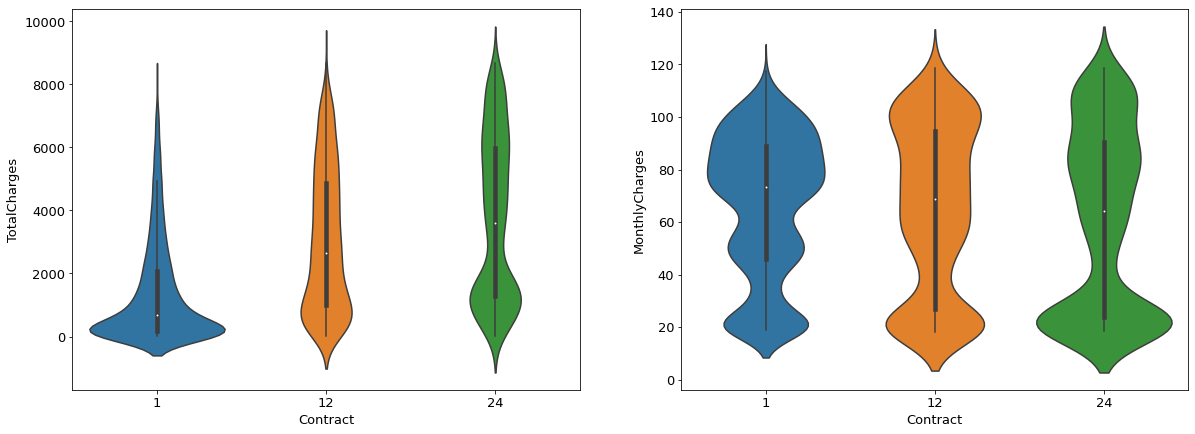

In [296]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
sns.violinplot(main_df['Contract'], main_df['TotalCharges'])
plt.subplot(1,2,2)
sns.violinplot(main_df['Contract'], main_df['MonthlyCharges'])
plt.show()

---------------
약정이 길면 길수록 MonthlyCharges는 낮은 곳에 많이 분포되어 있고,TotalCharges는 낮은 곳보단 윗쪽에 고루 분포되어 있다.<br>
장기 약정 가입자는 할인 혜택을 많이 받기 때문인 것 같다.

## 디지털 친화도(familiar_with_digital)와 Churn의 상관관계
    - 디지털 친화도 측정 방법: 백업, 보안, 다양한 서비스 이용여부 등 정보를 활용

In [297]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   int64   
 16  PaperlessBilling  7043 n

In [298]:
main_df.iloc[:,6:15]

,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,No,No phone service,DSL,No,Yes,No,No,No,No
1,Yes,No,DSL,Yes,No,Yes,No,No,No
2,Yes,No,DSL,Yes,Yes,No,No,No,No
3,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,Yes,No,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...
7038,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes
7039,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes
7040,No,No phone service,DSL,Yes,No,No,No,No,No
7041,Yes,Yes,Fiber optic,No,No,No,No,No,No


------------------
위 9개 서비스 이용을 많이할수록 디지털 친화도가 높다고 판단한다.

In [299]:
'''
DSL,Fiber optic, No Phone service 등 다양한 응답이 있으므로 
공백을 기준으로 split을 수행하고 첫번째 요소가 'No'만 아니면 친화도를 높인다(return 1)
'''

def count_digital(x):
    return  1 if x.split()[0]!='No' else 0

count_dig = [0 for _ in range(len(main_df))]
for e in range(6,15):
    for ind in range(len(main_df)):
        count_dig[ind] += count_digital(main_df.iloc[ind,e])
        
#디지털 친화도 컬럼 추가
main_df['familiar_with_digital'] = count_dig
main_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_bin,familiar_with_digital
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,1,Yes,Electronic check,29.85,29.85,No,0,2
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,12,No,Mailed check,56.95,1889.50,No,2,4
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,1,Yes,Mailed check,53.85,108.15,Yes,0,4
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,12,No,Bank transfer (automatic),42.30,1840.75,No,2,4
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,1,Yes,Electronic check,70.70,151.65,Yes,0,2


In [300]:
main_df.familiar_with_digital.describe()

count    7043.000000
mean        4.146244
std         2.312720
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: familiar_with_digital, dtype: float64

In [301]:
pd.pivot_table(main_df, index=['familiar_with_digital', 'Churn'])

Contract  MonthlyCharges  TotalCharges  \
familiar_with_digital Churn                                            
1                     No     12.153641       20.155906    544.216075   
                      Yes     1.971014       21.185870    122.361957   
2                     No     11.559865       36.192917    959.169646   
                      Yes     1.383459       54.948684    325.139662   
3                     No      3.351931       57.290343   1111.154077   
                      Yes     1.231579       67.107763    582.636579   
4                     No      6.277325       65.095106   1866.574551   
                      Yes     1.633523       76.776278   1184.418182   
5                     No      8.102686       75.061927   2736.084676   
                      Yes     2.349481       86.753633   1784.226644   
6                     No     11.585799       83.346302   3845.651849   
                      Yes     3.258621       94.932112   2678.174353   
7                     No     15.118321       91.180534   4935.668702   
                      Yes     6.210526      102.129276   4210.343421   
8                     No     17.930636       98.490462   5992.733092   
                      Yes    12.040816      106.041837   5456.477551   
9                     No     22.309645      104.135025   6949.129949   
                      Yes    13.363636      113.536364   6992.650000   

                                tenure  
familiar_with_digital Churn             
1                     No     27.081705  
                      Yes     5.934783  
2                     No     32.539629  
                      Yes     6.556391  
3                     No     20.324034  
                      Yes     9.021053  
4                     No     29.526917  
                      Yes    15.715909  
5                     No     37.080569  
                      Yes    21.044983  
6                     No     46.010355  
                      Yes    28.172414  
7                     No     53.931298  
                      Yes    41.118421  
8                     No     60.921965  
                      Yes    51.551020  
9                     No     66.558376  
                      Yes    62.363636

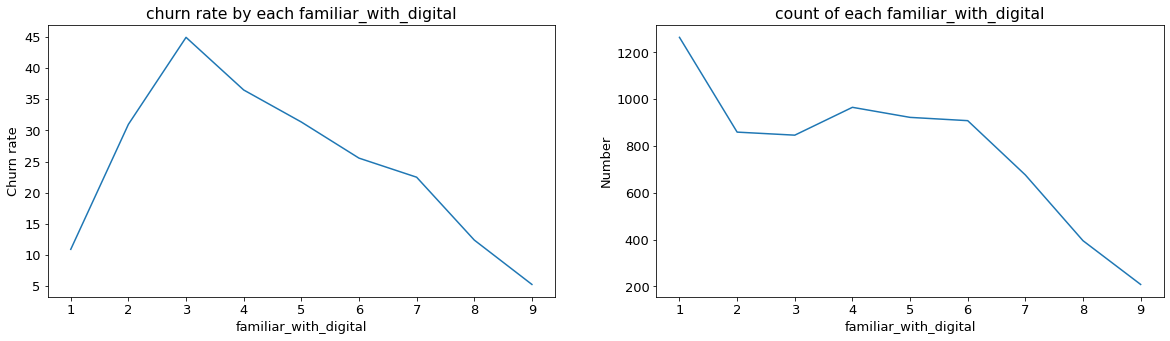

In [302]:
tmp_df = pd.DataFrame({'familiar_with_digital':[],'Churn rate':[],'Number':[]})
for i in range(1,10):
    target = main_df.loc[main_df.familiar_with_digital == i].Churn.value_counts()
    tmp_df = tmp_df.append({'familiar_with_digital':i,'Churn rate':round(target['Yes']/target.sum()*100,2),'Number':target.sum()},ignore_index=True)

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title("churn rate by each familiar_with_digital")
sns.lineplot(x=tmp_df['familiar_with_digital'], y= tmp_df['Churn rate'])
plt.subplot(1,2,2)
plt.title("count of each familiar_with_digital")
sns.lineplot(x=tmp_df['familiar_with_digital'], y= tmp_df['Number'])
# sns.lineplot(x=tmp_df['familiar_with_digital'], y= tmp_df['Churn rate'])
# sns.lineplot(x=tmp_df['familiar_with_digital'], y= tmp_df['Number'])
plt.show()

In [303]:
tmp_df

,familiar_with_digital,Churn rate,Number
0,1.0,10.92,1264.0
1,2.0,30.97,859.0
2,3.0,44.92,846.0
3,4.0,36.48,965.0
4,5.0,31.34,922.0
5,6.0,25.55,908.0
6,7.0,22.49,676.0
7,8.0,12.41,395.0
8,9.0,5.29,208.0


------------------
디지털 친화도가 3일때까지는 친화도가 높아질수록 해지할 확률도 높아지는 양의 관계를 보이다가, 4부터는 음의 관계를 보이고 있다.

## 수치형 컬럼들의 상관관계

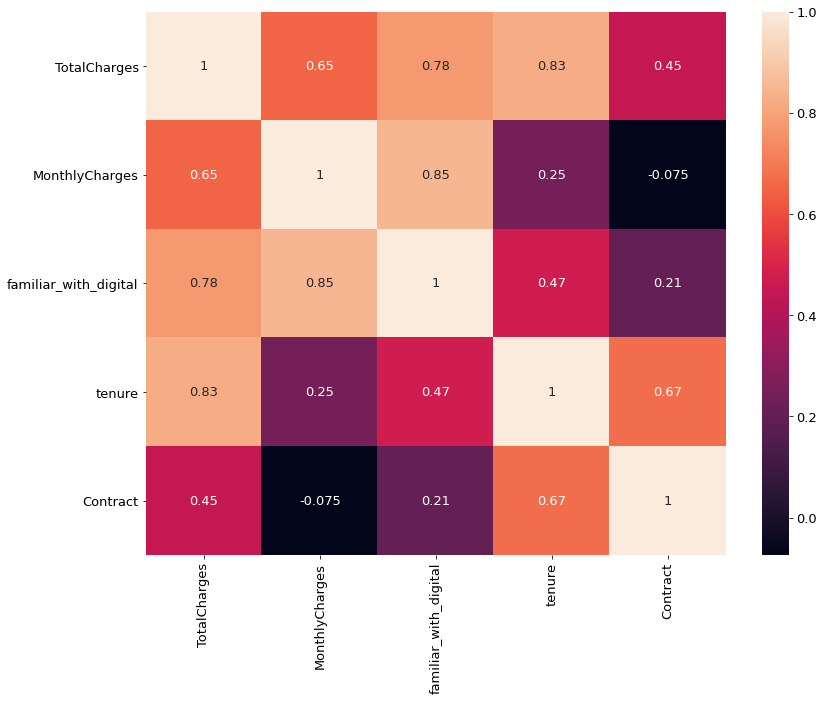

In [304]:
plt.figure(figsize=(13,10))
sns.heatmap(main_df[['TotalCharges', 'MonthlyCharges', 'familiar_with_digital','tenure','Contract']].corr(), annot=True)
plt.show()

-------------
양의 관계) *0.5이상
- familiar_with_digital 과 TotalCharges
- familiar_with_digital 과 MonthlyCharges
- tenure 과 TotalCharges
- tenure 과 Contract
- MonthlyCharges와 TotalCharges

## gender와 Churn의 상관관계

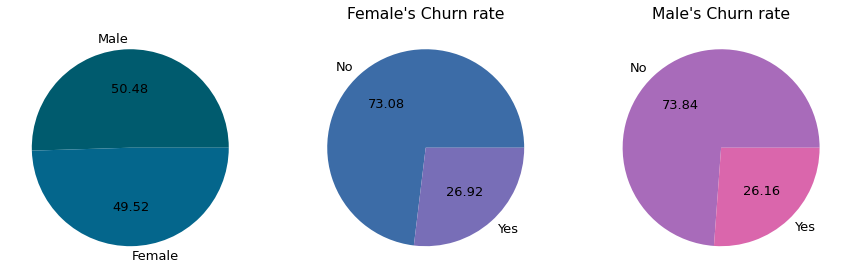

In [305]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.pie(main_df.gender.value_counts(), autopct="%.2f", labels =main_df.gender.value_counts().keys(),colors = color_dic[0])
#남녀 Yes/No 비율
fe = main_df.loc[main_df.gender=='Female']
ma = main_df.loc[main_df.gender=='Male']
plt.subplot(1,3,2)
plt.title("Female's Churn rate")
plt.pie(fe.Churn.value_counts(), labels = fe.Churn.value_counts().keys(), autopct = "%.2f", colors =color_dic[1])
plt.subplot(1,3,3)
plt.title("Male's Churn rate")
plt.pie(ma.Churn.value_counts(), labels = ma.Churn.value_counts().keys(), autopct = "%.2f", colors =color_dic[2])
plt.show()

------------
성비가 비슷하고, 성별로 계약 해지여부 비율도 비슷하다

In [306]:
pd.pivot_table(main_df, index=['gender','Churn'])

Contract  MonthlyCharges  TotalCharges  familiar_with_digital  \
gender Churn                                                                   
Female No     11.200863       61.664908   2591.628737               4.224009   
       Yes     2.417465       74.812087   1440.979499               4.074547   
Male   No     11.002286       60.876914   2513.477390               4.123810   
       Yes     2.719355       74.066989   1623.491559               4.068817   

                 tenure  
gender Churn             
Female No     37.858768  
       Yes    17.004260  
Male   No     37.289524  
       Yes    18.963441

--------------------------
성별에 상관없이 해지를 하지 않은 사람들은 해지한 사람들에 비해 모두 계약기간이 길고, 
<br>
월지불금액과 총지불금액이 모두 높다 그리고 근속월수도 길다. 
<br>
디지털 친화도는 다 비슷해서 큰 의미가 없는 것 같다.

## SeniorCitizen과 Churn의 상관관계

* 우선, SeniorCitizen의 나이 기준은 정해진 것이 없는데, 대부분 약 60대부터 해당된다고 한다.  참고: https://www.seniorliving.org/life/senior-citizen/
 <br><br>->The age of a senior citizen varies according to the source. For example, according to Medicare, a senior is 65 years old or older. However, Social Security benefits are eligible for seniors starting at 62, even though the Social Security Office reports that 67 is the age of retirement. Yet if you are 55 and you visit an Arby’s or McDonald’s you can get a senior discount. By the way, Burger King requires you to be at least 60.

In [307]:
main_df.loc[main_df.SeniorCitizen == 1]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_bin,familiar_with_digital
20,8779-QRDMV,Male,1,No,No,1,No,No phone service,DSL,No,...,No,Yes,1,Yes,Electronic check,39.65,39.65,Yes,0,3
30,3841-NFECX,Female,1,Yes,No,71,Yes,Yes,Fiber optic,Yes,...,No,No,24,Yes,Credit card (automatic),96.35,6766.95,No,4,7
31,4929-XIHVW,Male,1,Yes,No,2,Yes,No,Fiber optic,No,...,Yes,Yes,1,Yes,Credit card (automatic),95.50,181.65,No,0,5
34,3413-BMNZE,Male,1,No,No,1,Yes,No,DSL,No,...,No,No,1,No,Bank transfer (automatic),45.25,45.25,No,0,2
50,8012-SOUDQ,Female,1,No,No,43,Yes,Yes,Fiber optic,No,...,Yes,No,1,Yes,Electronic check,90.25,3838.75,No,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7023,1035-IPQPU,Female,1,Yes,No,63,Yes,Yes,Fiber optic,No,...,Yes,Yes,1,Yes,Electronic check,103.50,6479.40,No,4,7
7029,2235-DWLJU,Female,1,No,No,6,No,No phone service,DSL,No,...,Yes,Yes,1,Yes,Electronic check,44.40,263.05,No,0,3
7031,3605-JISKB,Male,1,Yes,No,55,Yes,Yes,DSL,Yes,...,No,No,12,No,Credit card (automatic),60.00,3316.10,No,3,5
7032,6894-LFHLY,Male,1,No,No,1,Yes,Yes,Fiber optic,No,...,No,No,1,Yes,Electronic check,75.75,75.75,Yes,0,3


In [308]:
pd.pivot_table(main_df, index=['SeniorCitizen'])

,Contract,MonthlyCharges,TotalCharges,familiar_with_digital,tenure
SeniorCitizen,,,,,
0,9.432977,61.847441,2178.836714,4.026097,32.192171
1,5.750438,79.820359,2810.465193,4.767075,33.295972


In [309]:
main_df.describe()

,tenure,Contract,MonthlyCharges,TotalCharges,familiar_with_digital
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,8.835865,64.761692,2281.253259,4.146244
std,24.559481,9.551444,30.090047,2265.703526,2.312720
min,0.000000,1.000000,18.250000,18.800000,1.000000
25%,9.000000,1.000000,35.500000,401.900000,2.000000
50%,29.000000,1.000000,70.350000,1396.250000,4.000000
75%,55.000000,12.000000,89.850000,3786.600000,6.000000
max,72.000000,24.000000,118.750000,8684.800000,9.000000


In [310]:
pd.pivot_table(main_df, index=['SeniorCitizen'])

,Contract,MonthlyCharges,TotalCharges,familiar_with_digital,tenure
SeniorCitizen,,,,,
0,9.432977,61.847441,2178.836714,4.026097,32.192171
1,5.750438,79.820359,2810.465193,4.767075,33.295972


In [311]:
from sklearn.preprocessing import MinMaxScaler
import copy
norm_df=copy.deepcopy(main_df)
scaler = MinMaxScaler()
norm_df[['Contract', 'MonthlyCharges','TotalCharges','familiar_with_digital','tenure']]=scaler.fit_transform(main_df[['Contract', 'MonthlyCharges','TotalCharges','familiar_with_digital','tenure']])

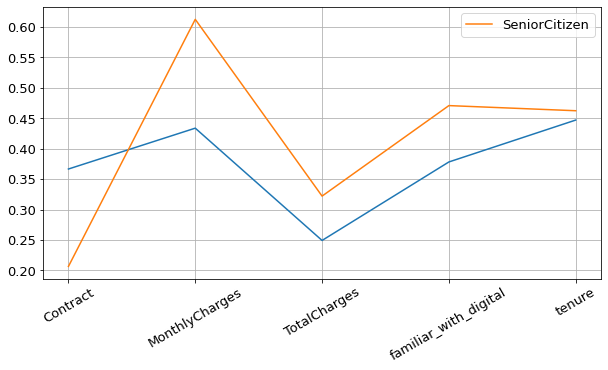

In [312]:
common = pd.pivot_table(norm_df, index=['SeniorCitizen']).transpose()
plt.figure(figsize=(10,5))
plt.plot(common[0])
plt.plot(common[1], label='SeniorCitizen')
plt.xticks(rotation=30)
plt.grid()
plt.legend(loc='upper right')
plt.show()

---------------
SeniorCitizen인 사람들(1)이 그렇지 않은 사람들(0)보다 계약기간은 짧지만 더 높은 금액을 지불하고 있고, 근속월수와 디지털 친화도가 조금 더 높다.<br>
TotalCharges의 차이보다 MonthlyCharges의 차이가 크다.

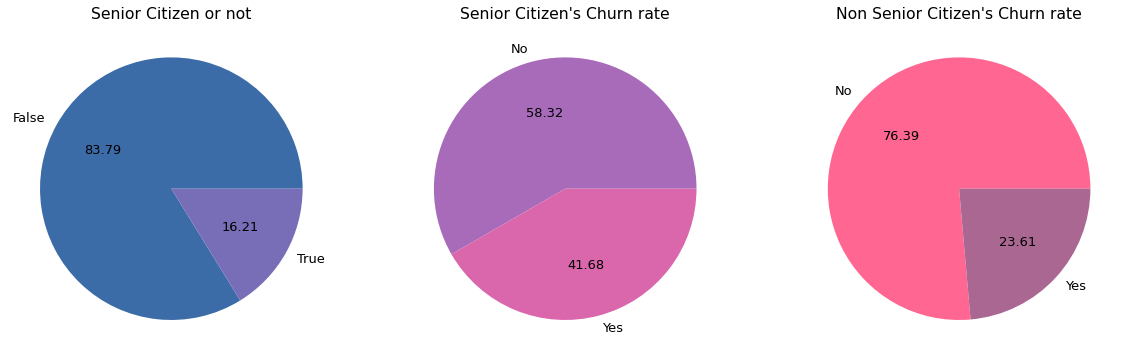

In [313]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title("Senior Citizen or not")
plt.pie(main_df.SeniorCitizen.value_counts(), autopct = "%.2f",labels = ['True'if k==1 else 'False' for k in main_df.SeniorCitizen.value_counts().keys()], 
        colors =color_dic[1])
plt.subplot(1,3,2)
plt.title("Senior Citizen's Churn rate")
plt.pie(main_df.loc[main_df.SeniorCitizen==1].Churn.value_counts(), autopct = "%.2f",labels = main_df.loc[main_df.SeniorCitizen==1].Churn.value_counts().keys(), 
        colors =color_dic[2])
plt.subplot(1,3,3)
plt.title("Non Senior Citizen's Churn rate")
plt.pie(main_df.loc[main_df.SeniorCitizen==0].Churn.value_counts(), autopct = "%.2f",labels = main_df.loc[main_df.SeniorCitizen==0].Churn.value_counts().keys(), 
        colors =color_dic[3])

plt.show()

---------------
Senior Citizen은 전체 고객의 16.21%에 해당하고, 이들 중 해지한 사람은 41.68%이다.<br>
Senior Citizen이 아닌 사람들 중 해지한 사람은 23.61%이다.


## Partner와 Churn의 상관관계

In [314]:
main_df.Partner.value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

In [315]:
pd.pivot_table(main_df, index=['Partner'])

,Contract,MonthlyCharges,TotalCharges,familiar_with_digital,tenure
Partner,,,,,
No,6.120022,61.945001,1584.631310,3.708871,23.357869
Yes,11.742504,67.776264,3026.814844,4.614345,42.017637


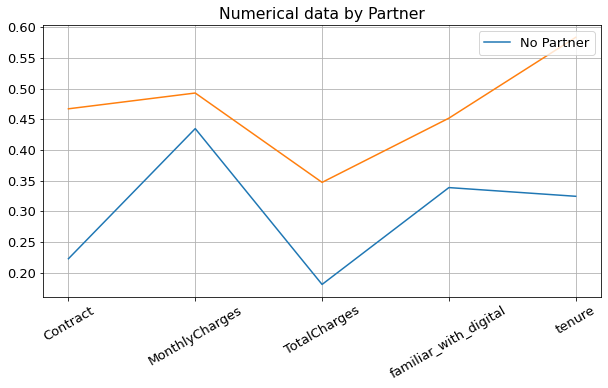

In [316]:
common = pd.pivot_table(norm_df, index=['Partner']).transpose()
plt.figure(figsize=(10,5))
plt.plot(common['No'],label='No Partner')
plt.plot(common['Yes'])
plt.xticks(rotation=30)
plt.grid()
plt.legend(loc='upper right')
plt.title("Numerical data by Partner")
plt.show()

--------
배우자가 있는 고객의 약정기간이 배우자가 없는 고객보다 더 길고, 더 많은 금액을 지불하고 있다. 그리고 디지털 친화도와 근속월수도 더 길다. <br> *뭐든 다 높다.
<br>
*특히 Contract와 TotalCharges 그리고 tenure의 값이 압도적으로 높다.


In [317]:
pd.pivot_table(main_df,index= ['Partner','Churn'])

Contract  MonthlyCharges  TotalCharges  familiar_with_digital  \
Partner Churn                                                                   
No      No      8.170422       57.271856   1828.294244               3.683327   
        Yes     1.949167       71.450958   1088.980292               3.760833   
Yes     No     13.716795       64.831742   3198.343780               4.610684   
        Yes     3.677130       79.805232   2326.084529               4.629297   

                  tenure  
Partner Churn             
No      No     28.362966  
        Yes    13.176667  
Yes     No     45.793267  
        Yes    26.593423

----------------------
위 테이블을 보면, <br>
배우자유무에 상관없이, 해지한 고객에 비해 해지하지 않은 고객들이
1. 약정기간이 길고, 
2. 월지불금액은 낮지만 전체지불금액이 높고, 
3. 디지털친화도가 아주 조금 더 낮고, 
4. 근속월수가 길다.
<br><br>

*TotalCharges와 Churn의 상관관계 분석을 통해서는 TotalCharges가 높을 수록 Churn=='No'일 확률이 높다는 것을 알고 있었다. <br>
*다음엔 MonthlyCharges와 Churn의 상관관계를 분석해봐야겠다.
<br>

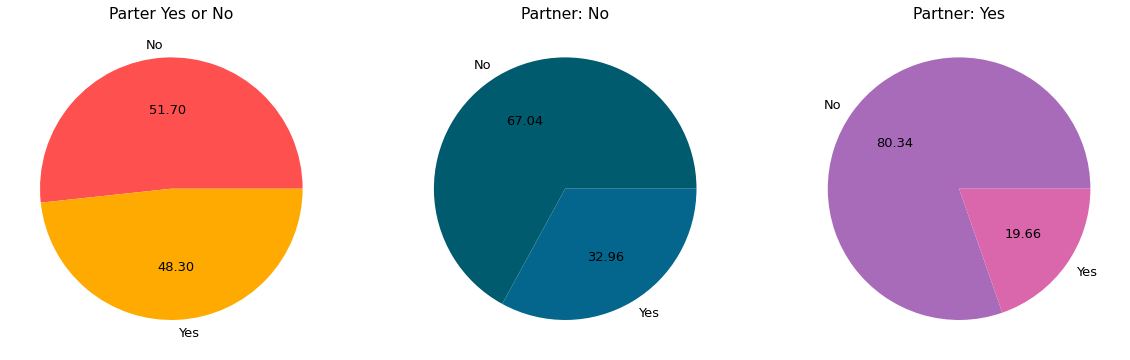

In [318]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title('Parter Yes or No')
plt.pie(main_df.Partner.value_counts(), autopct= "%.2f", labels = main_df.Partner.value_counts().keys(), colors=color_dic[5])
plt.subplot(1,3,2)
plt.title("Partner: No")
plt.pie(main_df.loc[main_df.Partner == 'No'].Churn.value_counts(),autopct = '%.2f',labels=main_df.loc[main_df.Partner == 'No'].Churn.value_counts().keys(),colors = color_dic[0])
plt.subplot(1,3,3)
plt.title("Partner: Yes")
plt.pie(main_df.loc[main_df.Partner == 'Yes'].Churn.value_counts(),autopct = '%.2f',labels=main_df.loc[main_df.Partner == 'Yes'].Churn.value_counts().keys(),colors = color_dic[2])
plt.show()

--------------------------------
배우자가 있는 사람보다 없는 사람의 해지비율이 더 높다.


## MonthlyCharges와 Churn의 상관관계

In [319]:
main_df.MonthlyCharges.describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

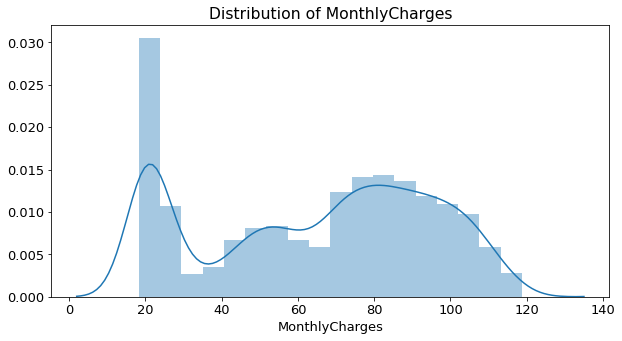

In [320]:
plt.figure(figsize=(10,5))
plt.title("Distribution of MonthlyCharges")
sns.distplot(main_df.MonthlyCharges)
plt.show()

--------------------------
MonthlyCharges의 값을 특정 구간으로 나눈 MonthlyCharges_bin이라는 컬럼을 하나 더 만들어서 살펴보자

- MonthlyCharges_bin

In [321]:
bins = [0]
for i in range(1,11,1):
    bins.append(main_df.MonthlyCharges.quantile(0.1*i))
main_df['MonthlyCharges_bin'] = pd.cut(main_df.MonthlyCharges, bins, labels = list(range(len(bins)-1)))
pd.DataFrame(bins)

,0
0,0.00
1,20.05
2,25.05
3,45.85
4,58.83
5,70.35
6,79.10
7,85.50
8,94.25
9,102.60


In [322]:
pd.DataFrame(main_df.MonthlyCharges_bin.value_counts())

,MonthlyCharges_bin
0,717
4,711
6,705
9,704
8,704
1,703
7,702
3,702
5,700
2,695


--------------------
MonthlyCharges값을 백분율 10%단위로 끊어서 MonthlyCharges_bin컬럼을 만들어보았다. 

In [323]:
pd.pivot_table(main_df, index=['MonthlyCharges_bin', 'Churn'])

Contract  MonthlyCharges  TotalCharges  \
MonthlyCharges_bin Churn                                            
0                  No     12.875000       19.630335    557.844893   
                   Yes     2.475410       19.622131    154.021311   
1                  No     13.550473       21.792902    724.897555   
                   Yes     2.463768       22.000000    138.278261   
2                  No     10.206564       34.825000   1040.363900   
                   Yes     1.627119       38.300565    370.748870   
3                  No      7.209434       52.746698   1518.830943   
                   Yes     2.244186       51.949128    681.456977   
4                  No     10.428315       64.790502   2318.395878   
                   Yes     2.594771       67.425163    775.958824   
5                  No      8.921478       74.661085   2532.951155   
                   Yes     1.539326       74.693071    844.069663   
6                  No     11.036530       82.134132   3436.486187   
                   Yes     1.797753       82.210300   1332.217228   
7                  No      9.880694       89.854338   3976.488720   
                   Yes     1.975104       89.885477   1612.587137   
8                  No      9.651442       98.036418   4506.473077   
                   Yes     2.465278       98.065278   2534.344618   
9                  No     15.473585      108.744057   6473.682642   
                   Yes     7.643678      106.821839   4843.920690   

                          familiar_with_digital     tenure  
MonthlyCharges_bin Churn                                    
0                  No                  1.000000  28.304878  
                   Yes                 1.000000   7.786885  
1                  No                  1.288644  32.509464  
                   Yes                 1.086957   6.246377  
2                  No                  2.517375  31.162162  
                   Yes                 2.288136   9.988701  
3                  No                  3.898113  28.479245  
                   Yes                 3.482558  12.941860  
4                  No                  4.980287  35.965950  
                   Yes                 3.137255  11.849673  
5                  No                  4.896074  33.893764  
                   Yes                 3.161049  11.277154  
6                  No                  5.605023  41.815068  
                   Yes                 3.985019  16.168539  
7                  No                  5.995662  44.180043  
                   Yes                 4.751037  17.854772  
8                  No                  6.016827  45.860577  
                   Yes                 5.753472  25.715278  
9                  No                  7.788679  59.371698  
                   Yes                 7.356322  45.132184

In [324]:
tmp_df = pd.DataFrame({'MonthlyCharges_bin':[],'Churn rate':[]})
for i in range(10):
    target = main_df.loc[main_df.MonthlyCharges_bin == i].Churn.value_counts()
    tmp_df = tmp_df.append({'MonthlyCharges_bin':i,'Churn rate':round(target['Yes']/target.sum()*100,2)},ignore_index=True)

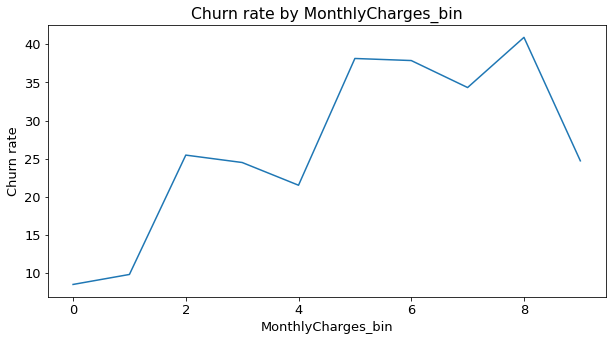

In [325]:
plt.figure(figsize=(10,5))
sns.lineplot(x=tmp_df['MonthlyCharges_bin'], y= tmp_df['Churn rate'])
plt.title("Churn rate by MonthlyCharges_bin")
plt.show()

-----------------
MonthlyCharges_bin의 값과 해지율이 선형적인 관계를 가질 줄 알았다.<br>
하지만 bin이 5-8인경우에 해지율이 가장 높고, bin이 0-1인경우 해지율이 가장 낮았다. 나머지는 20%대로 비슷하다.<br>
해당 컬럼도 충분히 의미 있을 수 있지만, 선형적인 관계를 만들어보고 싶기에 MonthlyCharges_bin2 컬럼을 만들어보기로 했다.

- MonthlyCharges_bin2

In [326]:
bins = [0,main_df.MonthlyCharges.quantile(.35),main_df.MonthlyCharges.quantile(.65),
        main_df.MonthlyCharges.quantile(1)]
bins

[0, 53.13499999999999, 81.45, 118.75]

In [327]:
main_df['MonthlyCharges_bin2'] = pd.cut(main_df.MonthlyCharges, bins, labels = list(range(len(bins)-1)))
main_df.MonthlyCharges_bin2.value_counts()

0    2465
2    2462
1    2116
Name: MonthlyCharges_bin2, dtype: int64

-------
0,백분율 35%의 값, 65%의 값, 최댓값을 구간의 경계값으로 설정했다. 각 구간에 속한 고객수는 2000대 초반~중반으로 맞추었다.


In [328]:
pd.pivot_table(main_df, index=['MonthlyCharges_bin2', 'Churn'])

Contract  MonthlyCharges  TotalCharges  \
MonthlyCharges_bin2 Churn                                            
0                   No     11.563107       27.808641    817.681699   
                    Yes     1.940741       35.414321    330.049012   
1                   No      9.659045       68.177236   2400.677707   
                    Yes     2.030207       71.798092    880.155087   
2                   No     11.830977       97.308175   4886.114167   
                    Yes     3.276647       95.361737   2605.556287   

                           familiar_with_digital     tenure  
MonthlyCharges_bin2 Churn                                    
0                   No                  1.773301  29.964078  
                    Yes                 2.091358   9.051852  
1                   No                  4.880968  35.015467  
                    Yes                 3.362480  12.451510  
2                   No                  6.564843  49.534726  
                    Yes                 5.566467  26.473054

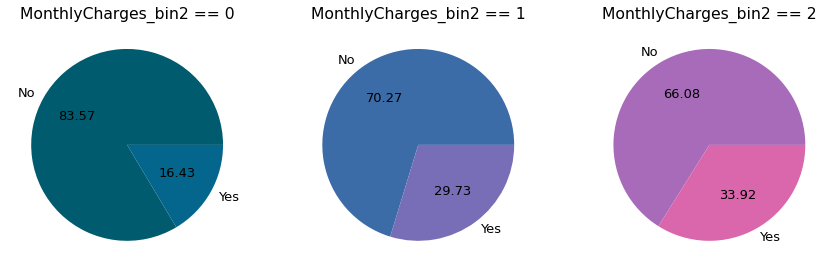

In [329]:
plt.figure(figsize=(20,15))

for e in range(3):
    plt.subplot(3,4,e+1)
    target =main_df.loc[main_df.MonthlyCharges_bin2 == e].Churn.value_counts() 
    plt.pie(target, autopct="%.2f", labels =target.keys(),colors=color_dic[e])
    plt.title(f"MonthlyCharges_bin2 == {e}")
plt.show()


In [330]:
def get_pct(target):
    pct= {}
    for i in main_df[target].unique():
        val_c = main_df.loc[main_df[target]==i].Churn.value_counts()
        pct[i] = round(val_c['Yes']/val_c.sum()*100,2)#churn rate
    return pct

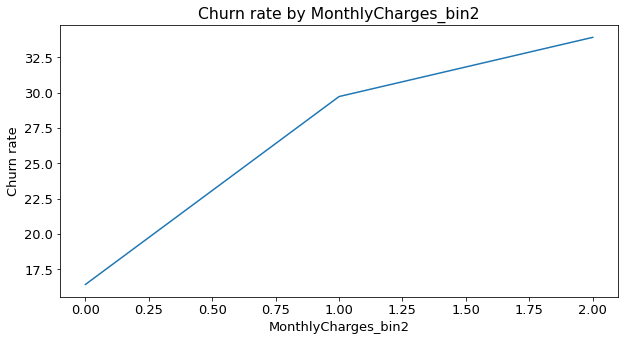

In [331]:

pct=get_pct('MonthlyCharges_bin2')
plt.figure(figsize=(10,5))
sns.lineplot(x=list(range(3)), y=list(pct.values()))
plt.title("Churn rate by MonthlyCharges_bin2")
plt.xlabel("MonthlyCharges_bin2")
plt.ylabel('Churn rate')
plt.show()

-----------
이렇게 세구간으로 나누니 bin값이 커질수록 해지율이 높아지는 선형적인 관계를 가지게 되었다.<br>


In [332]:
main_df['MonthlyCharges_bin2']=main_df.MonthlyCharges_bin2.astype('int')

--------------------------------------------------------
따라서 MonthlyCharges_bin2값의 크기가 의미를 가지므로 category -> int로 형변환을 해주었다.

## Dependents와 Churn의 상관관계

In [333]:
main_df.Dependents.value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

In [334]:
pd.pivot_table(main_df, index=['Dependents'])

,Contract,MonthlyCharges,MonthlyCharges_bin2,TotalCharges,familiar_with_digital,tenure
Dependents,,,,,,
No,7.320089,67.002808,1.050274,2187.709254,4.155686,29.806000
Yes,12.379621,59.522156,0.881043,2499.951161,4.124171,38.368246


----------------------
부양가족이 있는 고객들이 없는 고객에 비해 약정기간이 길고, 월 지불 금액이 낮고 전체 지불 금액은 높다. 그리고 근속월수도 더 길다.


***->부양가족이 있는 고객들의 해지율이 낮을 것으로 예상한다***


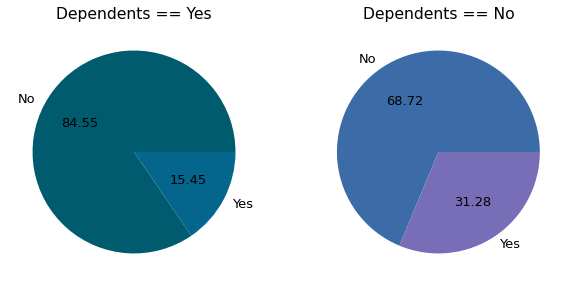

In [335]:
target_yes = main_df.loc[main_df.Dependents=='Yes'].Churn.value_counts()
target_yes = main_df.loc[main_df.Dependents=='No'].Churn.value_counts()
plt.figure(figsize=(10,10))
for e,ans in enumerate(['Yes','No']):
    plt.subplot(1,2,e+1)
    target= main_df.loc[main_df.Dependents==ans,'Churn'].value_counts()
    plt.pie(target, autopct='%.2f', labels=target.keys(),colors=color_dic[e])
    plt.title(f"Dependents == {ans}")

plt.show()

-----------------
예상대로 부양가족이 있는 고객들의 해지율이 더 낮다.

## PaymentMethod와 Churn의 상관관계

In [336]:
pd.pivot_table(main_df, index=['PaymentMethod'])

,Contract,MonthlyCharges,MonthlyCharges_bin2,TotalCharges,familiar_with_digital,tenure
PaymentMethod,,,,,,
Bank transfer (automatic),12.187176,67.192649,1.065415,3077.089832,4.630181,43.656736
Credit card (automatic),12.656373,66.512385,1.053876,3070.261859,4.664258,43.269382
Electronic check,4.247780,76.255814,1.287949,2090.868182,4.416913,25.174630
Mailed check,8.750000,43.917060,0.462159,1053.348759,2.796526,21.830025


In [338]:
common = main_df['PaymentMethod'].value_counts()

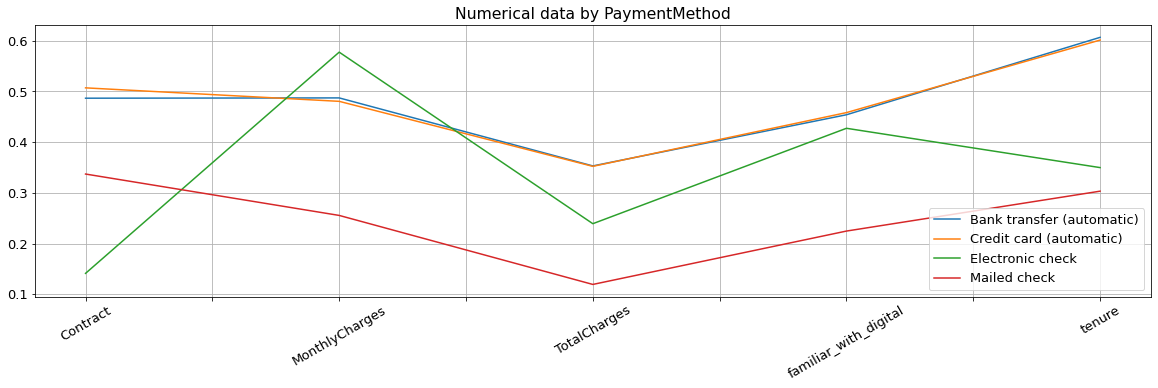

In [342]:
pct = get_pct('PaymentMethod')
pd.pivot_table(norm_df, index=['PaymentMethod']).transpose().plot(figsize=(20,5),grid=True)
plt.title("Numerical data by PaymentMethod")
plt.xticks(rotation=30)
plt.legend(loc='lower right')
plt.show()

------------------
- Bank transfer와 Credit card는 수치형 컬럼들의 값들이 비슷한 추세를 보이고 있다. -> MonthlyCharges를 제외하고 모든 컬럼값이 가장 크다. 
- Electronic check는 Contract값이 가장 작고, MonthlyCharges값은 가장 크다.
- Mailed check는 Contract를 제외하고 모든 컬럼값이 가장 작다.

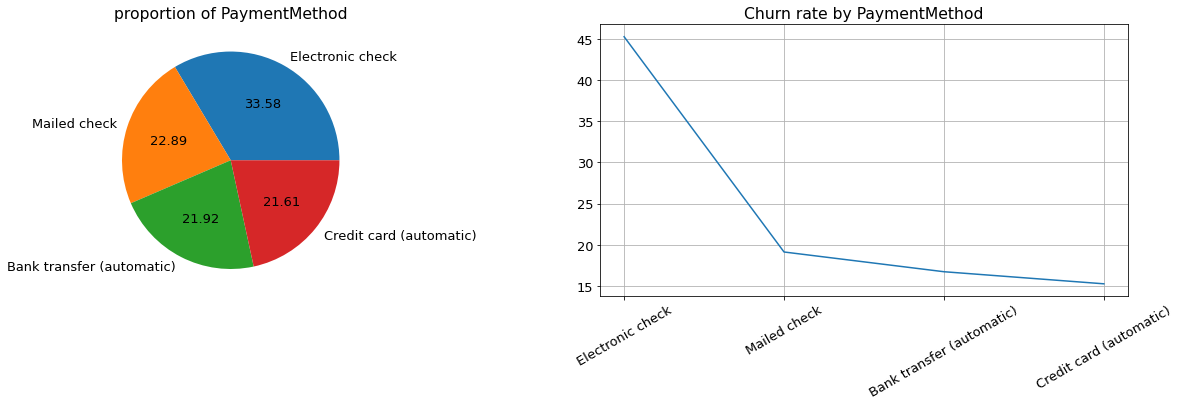

In [343]:
plt.figure(figsize=(15,5))
plt.subplots_adjust(right=1.2)
plt.subplot(1,2,1)
plt.title("proportion of PaymentMethod")
plt.pie(common,labels = common.keys(),autopct = "%.2f")
plt.subplot(1,2,2)
plt.title("Churn rate by PaymentMethod")
plt.plot(pd.DataFrame(pct.values(),columns=['churn rate'],index = pct.keys()))
plt.grid()
plt.xticks(rotation=30)
plt.show()

---------------------------

- 
- 

In [344]:
pd.pivot_table(main_df, index=['PaymentMethod','Churn'])

Contract  MonthlyCharges  \
PaymentMethod             Churn                              
Bank transfer (automatic) No     13.766719       65.049417   
                          Yes     4.313953       77.875581   
Credit card (automatic)   No     14.171318       64.562209   
                          Yes     4.232759       77.356034   
Electronic check          No      6.160742       74.232032   
                          Yes     1.936508       78.700980   
Mailed check              No     10.333589       41.403911   
                          Yes     2.045455       54.557143   

                                 MonthlyCharges_bin2  TotalCharges  \
PaymentMethod             Churn                                      
Bank transfer (automatic) No                1.015552   3239.047395   
                          Yes               1.313953   2269.812984   
Credit card (automatic)   No                1.006977   3199.750969   
                          Yes               1.314655   2350.257759   
Electronic check          No                1.237249   2609.989838   
                          Yes               1.349206   1463.656769   
Mailed check              No                0.410276   1176.011695   
                          Yes               0.681818    534.022565   

                                 familiar_with_digital     tenure  
PaymentMethod             Churn                                    
Bank transfer (automatic) No                  4.656299  47.140747  
                          Yes                 4.500000  26.290698  
Credit card (automatic)   No                  4.661240  46.101550  
                          Yes                 4.681034  27.521552  
Electronic check          No                  4.632148  32.136012  
                          Yes                 4.156863  16.763772  
Mailed check              No                  2.758436  25.083589  
                          Yes                 2.957792   8.055195

## SeniorCitizen과 Partner의 상관관계

In [251]:
pd.pivot_table(main_df, index=['SeniorCitizen','Partner'])

Contract  MonthlyCharges  MonthlyCharges_bin2  \
SeniorCitizen Partner                                                   
0             No        6.517578       59.186605             0.837891   
              Yes      12.598798       64.736833             1.016260   
1             No        3.973638       76.837434             1.298770   
              Yes       7.514834       82.782461             1.486911   

                       TotalCharges  familiar_with_digital     tenure  
SeniorCitizen Partner                                                  
0             No        1497.472721               3.594076  23.037760  
              Yes       2918.727200               4.495228  42.132909  
1             No        2055.195782               4.328647  25.086116  
              Yes       3560.462216               5.202443  41.448517

<br><br><br>
# 모델 적용 및 평가

<br>

## Under Sampling

In [345]:
#수치화
main_df['Churn']= main_df['Churn'].replace({'Yes':1, 'No':0})
from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()
for c in main_df.columns:
    main_df[c]= Encoder.fit_transform(main_df[c])

In [346]:
from imblearn.under_sampling import *

Using TensorFlow backend.


In [347]:
#sampling 이전
main_df['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [348]:
X_under, Y_under = RandomUnderSampler(random_state=0).fit_sample(main_df[main_df.columns], main_df['Churn'])
Y_under.value_counts()

1    1869
0    1869
Name: Churn, dtype: int64

In [349]:
X_under

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_bin,familiar_with_digital,MonthlyCharges_bin,MonthlyCharges_bin2
0,6931,1,0,1,1,42,1,2,1,2,...,1,0,2,1229,4913,0,3,5,8,2
1,2310,1,0,0,1,1,1,0,2,1,...,0,1,3,13,7,0,0,0,0,0
2,2541,0,0,1,0,58,1,2,0,0,...,2,1,1,541,4647,0,3,4,4,1
3,1505,1,0,0,0,56,1,2,1,0,...,0,0,2,1254,5651,0,4,5,8,2
4,5047,1,0,1,1,43,1,2,0,2,...,1,1,1,752,4470,0,3,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3733,1155,1,0,0,0,12,1,0,0,0,...,1,1,2,539,2022,1,1,3,4,1
3734,6201,0,0,0,0,9,1,0,0,0,...,0,1,0,289,1388,1,1,1,2,0
3735,4893,1,1,0,0,1,1,2,1,0,...,0,1,2,822,356,1,0,2,5,1
3736,437,0,0,0,0,67,1,2,1,2,...,0,1,1,1335,6179,1,4,6,9,2


<br>

## Over Sampling

In [350]:
from imblearn.over_sampling import *

In [351]:
X_over, Y_over = RandomOverSampler(random_state=0).fit_sample(main_df[main_df.columns], main_df['Churn'])
Y_over.value_counts()

1    5174
0    5174
Name: Churn, dtype: int64

In [352]:
X_over

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_bin,familiar_with_digital,MonthlyCharges_bin,MonthlyCharges_bin2
0,5375,0,0,1,0,1,0,1,0,0,...,0,1,2,142,74,0,0,1,2,0
1,3962,1,0,0,0,34,1,0,0,2,...,1,0,3,498,3634,0,2,3,3,1
2,2564,1,0,0,0,2,1,0,0,2,...,0,1,3,436,536,1,0,3,3,1
3,5535,1,0,0,0,45,0,1,0,2,...,1,0,0,266,3580,0,2,3,2,0
4,6511,0,0,0,0,2,1,0,1,0,...,0,1,2,729,674,1,0,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10343,3872,0,0,1,0,7,1,0,1,0,...,0,1,2,922,1759,1,1,2,6,1
10344,4725,0,0,0,0,1,1,0,1,0,...,0,1,2,721,302,1,0,1,4,1
10345,2547,1,1,1,0,7,1,2,1,0,...,0,1,0,1200,1874,1,1,4,8,2
10346,6966,0,1,0,0,1,1,0,1,0,...,0,0,2,869,373,1,0,2,5,1


In [353]:
#smote--------------------------------------------
smote = SMOTE(random_state=0)
X_smote, Y_smote = smote.fit_sample(main_df[main_df.columns], main_df['Churn'])

In [354]:
Y_smote.value_counts()

1    5174
0    5174
Name: Churn, dtype: int64

In [355]:
X_smote

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_bin,familiar_with_digital,MonthlyCharges_bin,MonthlyCharges_bin2
0,5375,0,0,1,0,1,0,1,0,0,...,0,1,2,142,74,0,0,1,2,0
1,3962,1,0,0,0,34,1,0,0,2,...,1,0,3,498,3634,0,2,3,3,1
2,2564,1,0,0,0,2,1,0,0,2,...,0,1,3,436,536,1,0,3,3,1
3,5535,1,0,0,0,45,0,1,0,2,...,1,0,0,266,3580,0,2,3,2,0
4,6511,0,0,0,0,2,1,0,1,0,...,0,1,2,729,674,1,0,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10343,2156,1,0,0,0,1,1,1,1,0,...,0,1,2,1044,644,1,0,3,7,2
10344,2332,1,0,0,0,16,1,2,0,0,...,0,1,1,1007,2949,1,2,3,6,2
10345,1879,0,0,0,0,14,1,2,1,0,...,0,1,2,898,2761,1,2,2,5,1
10346,1382,0,0,0,0,18,1,2,0,0,...,0,1,1,1002,3276,1,2,4,6,1


<br>

## Feature Selection

In [356]:
feature_all = main_df.columns.drop(['Churn','customerID'])
feature_all

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'TotalCharges_bin',
       'familiar_with_digital', 'MonthlyCharges_bin', 'MonthlyCharges_bin2'],
      dtype='object')

In [357]:
#familiar_with_digital이 TotalCharges, MonthlyCharges와 높은 양의 관계를 가지므로 해당 컬럼 하나만 적용 
feature1 = ['Contract','familiar_with_digital', 'tenure'] 
feature2 =  ['Contract','familiar_with_digital', 'tenure','SeniorCitizen'] 
feature3,feature4 = feature2[:],feature2[:]
feature3.append('MonthlyCharges_bin')
feature4.append('MonthlyCharges_bin2')


------------------------------------------
위 분석을 토대로 피처선택

<br>

## Model Building & Results

In [358]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
lgbm_clf = LGBMClassifier()
rf_clf = RandomForestClassifier()
gb_clf = GradientBoostingClassifier()
dt_clf = DecisionTreeClassifier()
svm_clf = svm.SVC(probability = True)
nb_clf = MultinomialNB()
log_clf = LogisticRegression()

names = ['RF','GB','DT','SVM','NB','LOG','LGBM']
model_dic = {'dt': dt_clf, 'svm':svm_clf, 'nb':nb_clf,'log':log_clf, 'gb':gb_clf, 'rf':rf_clf, 'lgbm':lgbm_clf}
target_dic = {'smote':[X_smote, Y_smote],'main':[main_df,main_df['Churn']],'over':[X_over,Y_over], 'under':[X_under,Y_under]}

#get cross_val_score
def get_score(model, feature, custom_cv,target):
    model = model.lower()
    X,Y = target_dic[target]
    return cross_val_score(model_dic[model],X[feature],Y,cv=custom_cv).mean()

#results visualization
def figure_results(model, feature,target):
    X,Y = target_dic[target]
    X_train, X_test, y_train, y_test = train_test_split(X[feature],Y,test_size=0.3,random_state=0)
    model_dic[model.lower()].fit(X_train,y_train)
    
    predictions = model_dic[model.lower()].predict(X_test)
    probabilities = model_dic[model.lower()].predict_proba(X_test)
    auc_score = roc_auc_score(y_test,predictions)
    
    conf_matrix = confusion_matrix(y_test,predictions)
    fpr,tpr,thresholds = roc_curve(y_test,probabilities[::,1])
    print (f"\n {model.upper()} Classification report : \n",classification_report(y_test,predictions))
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.subplots_adjust(top=0.8)
    plt.suptitle(f"input:{target}, model:{model}\n\n",fontsize=20)
    plt.title("confusion matrix")
    sns.heatmap(conf_matrix,annot=True,fmt = "d",square = True,
                xticklabels=["not churn","churn"],
                yticklabels=["not churn","churn"],
                linewidths = 2,linecolor = "w",cmap = "Set1")
    plt.ylabel('actual')
    plt.xlabel('predicted')
    
    plt.subplot(1,2,2)
    plt.title(f"roc curve: {round(auc_score,3)}")
    sns.scatterplot(x=fpr,y=tpr)
    sns.lineplot(x=[0,1], y=[0,1])
    plt.ylabel('TPR')
    plt.xlabel('FPR')

- cross-validation

In [359]:

score_df = pd.DataFrame({'model':[], 'feature':[], 'score':[], 'cv': [],'target':[]})
for n in names[3:]:
    score_df = score_df.append({'model':n,'feature':'2','score':get_score(n,feature2,10,'main'),'cv':10,'target':'main_df'}, ignore_index=True)
    score_df = score_df.append({'model':n,'feature':'2','score':get_score(n,feature2,10,'under'),'cv':10,'target':'under'}, ignore_index=True)
    score_df = score_df.append({'model':n,'feature':'2','score':get_score(n,feature2,10,'over'),'cv':10,'target':'over'}, ignore_index=True)
    score_df = score_df.append({'model':n,'feature':'2','score':get_score(n,feature2,10,'smote'),'cv':10,'target':'smote'},ignore_index=True)
score_df

,model,feature,score,cv,target
0,SVM,2,0.770838,10.0,main_df
1,SVM,2,0.704376,10.0,under
2,SVM,2,0.722556,10.0,over
3,SVM,2,0.726326,10.0,smote
4,NB,2,0.757208,10.0,main_df
5,NB,2,0.733012,10.0,under
6,NB,2,0.732026,10.0,over
7,NB,2,0.729417,10.0,smote
8,LOG,2,0.759906,10.0,main_df
9,LOG,2,0.735688,10.0,under


In [360]:
score_df2 = pd.DataFrame({'model':[], 'feature':[], 'score':[], 'cv': [],'target':[]})
for n in names[4:]:
    score_df2 = score_df2.append({'model':n,'feature':'all','score':get_score(n,feature_all,10,'main'),'cv':10,'target':'main_df'}, ignore_index=True)
    score_df2 = score_df2.append({'model':n,'feature':'all','score':get_score(n,feature_all,10,'under'),'cv':10,'target':'under'}, ignore_index=True)
    score_df2 = score_df2.append({'model':n,'feature':'all','score':get_score(n,feature_all,10,'over'),'cv':10,'target':'over'}, ignore_index=True)
    score_df2 = score_df2.append({'model':n,'feature':'all','score':get_score(n,feature_all,10,'smote'),'cv':10,'target':'smote'},ignore_index=True)
score_df2

,model,feature,score,cv,target
0,NB,all,0.751525,10.0,main_df
1,NB,all,0.733005,10.0,under
2,NB,all,0.733089,10.0,over
3,NB,all,0.733959,10.0,smote
4,LOG,all,0.802357,10.0,main_df
5,LOG,all,0.760829,10.0,under
6,LOG,all,0.759278,10.0,over
7,LOG,all,0.793687,10.0,smote
8,LGBM,all,0.795256,10.0,main_df
9,LGBM,all,0.757615,10.0,under


In [361]:
#결과 합치기
results = pd.concat([score_df,score_df2], axis=0)

In [362]:
pd.pivot_table(results, index=['target','model'])

cv     score
target  model                
main_df LGBM   10.0  0.785746
        LOG    10.0  0.781131
        NB     10.0  0.754367
        SVM    10.0  0.770838
over    LGBM   10.0  0.793731
        LOG    10.0  0.748648
        NB     10.0  0.732557
        SVM    10.0  0.722556
smote   LGBM   10.0  0.801131
        LOG    10.0  0.772087
        NB     10.0  0.731688
        SVM    10.0  0.726326
under   LGBM   10.0  0.746115
        LOG    10.0  0.748258
        NB     10.0  0.733008
        SVM    10.0  0.704376

---------
샘플링한것 중에서는 smote가 가장 성능이 좋은 것으로 보인다.<br>

- 결과 시각화


 RF Classification report : 
               precision    recall  f1-score   support

           0       0.85      0.84      0.84      1547
           1       0.84      0.85      0.85      1558

    accuracy                           0.84      3105
   macro avg       0.84      0.84      0.84      3105
weighted avg       0.84      0.84      0.84      3105


 LOG Classification report : 
               precision    recall  f1-score   support

           0       0.82      0.79      0.81      1547
           1       0.80      0.82      0.81      1558

    accuracy                           0.81      3105
   macro avg       0.81      0.81      0.81      3105
weighted avg       0.81      0.81      0.81      3105


 LGBM Classification report : 
               precision    recall  f1-score   support

           0       0.85      0.84      0.84      1547
           1       0.84      0.85      0.85      1558

    accuracy                           0.85      3105
   macro avg       0.85      0.8

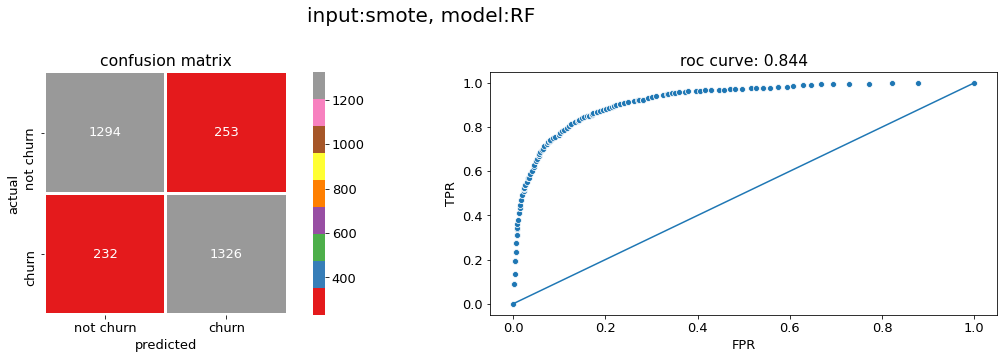

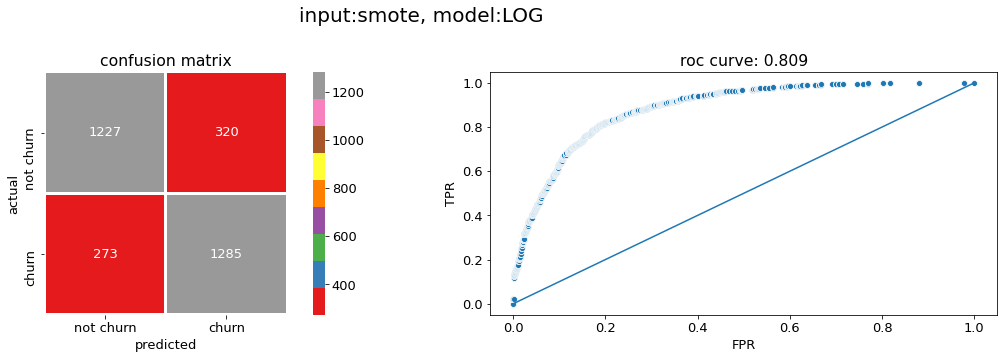

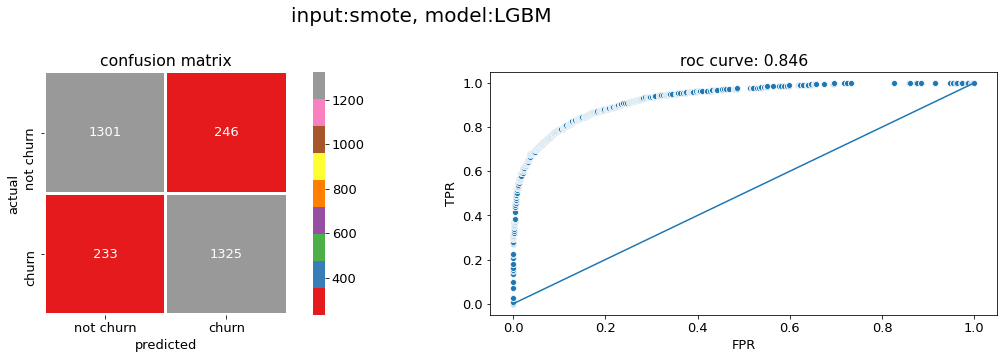

In [363]:
for model in ['RF','LOG','LGBM']:
    figure_results(model, feature_all,'smote')


 RF Classification report : 
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      1560
           1       0.63      0.52      0.57       553

    accuracy                           0.80      2113
   macro avg       0.74      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113


 LOG Classification report : 
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      1560
           1       0.63      0.52      0.57       553

    accuracy                           0.80      2113
   macro avg       0.74      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113


 LGBM Classification report : 
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1560
           1       0.60      0.52      0.56       553

    accuracy                           0.79      2113
   macro avg       0.72      0.7

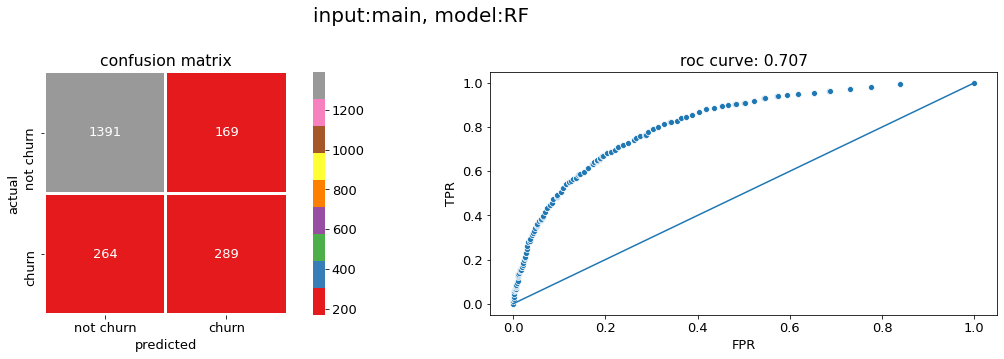

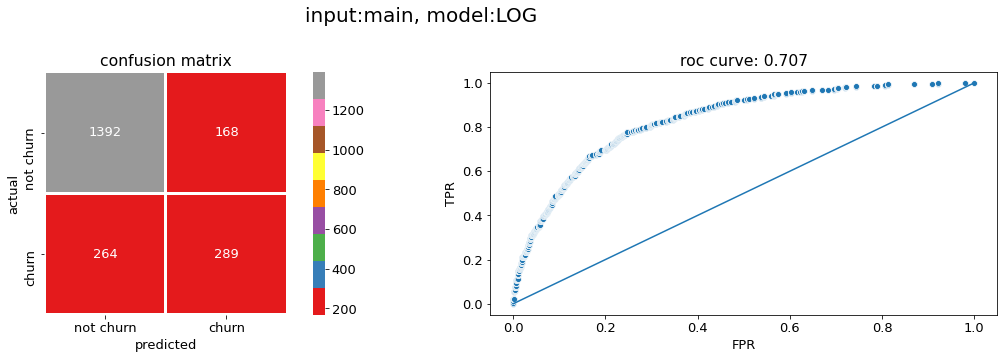

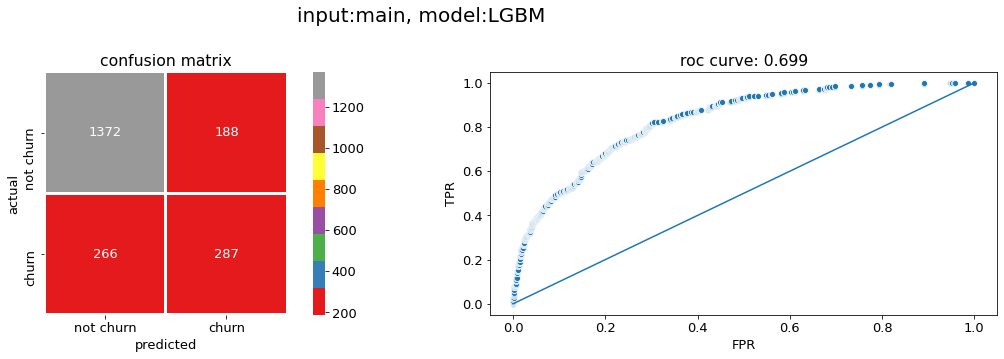

In [364]:
for model in ['RF','LOG','LGBM']:
    figure_results(model, feature_all,'main')

In [365]:
# from sklearn.model_selection import GridSearchCV
# params = {'n_estimators': [i for i in range(10,100,15)], 'max_depth':[i for i in range(3,20,5)],
#          'min_samples_leaf':[i for i in range(5,20,5)], 'min_samples_split':[i for i in range(10,50,10)]}
# grid_cv = GridSearchCV(rf_clf, param_grid = params, cv=6, n_jobs = -1, verbose=3)#n_jobs=-1: 모든 코어 사용,verbose: 로그출력 레벨 조정 
# grid_cv.fit(main_df[feature_all], main_df['Churn'])


In [366]:
# print("최적 하이퍼 파라미터", grid_cv.best_params_)

In [367]:

# print("최고 예측 정확도:{:.3f}".format(grid_cv.best_score_))

-----------------------------
# 앞으로 남은 일
<개별 속성과 Churn의 상관관계 분석>
- PaymentMethod와 Churn의 상관관계 분석(개별 속성값 관찰 마무리)<br><br>

<속성 간의 관계 관찰>
- Senior와 Partner의 상관관계 분석
- PaymentMethod와 Total&MonthCharges의 상관관계 분석
- familiar_with_digital개선 (지금은 별 의미 없어 보임)
- 모두 수치화해서 모든 컬럼별 상관관계 분석
- familiar_with_digital에서 Charges랑 관련있는거 빼보기<br><br>

<br><br>
<모델 최적화>
- Grid search cv
- category 타입 one hot encoding 꼭 해야하나? (한것, 안한것 비교해보기)
https://medium.com/analytics-vidhya/data-cleaning-and-preprocessing-a4b751f4066f
<br><br>

<분석 내용 총정리>
- EDA, 결과에 대한 해석 정리